
📊 Model Evaluation Metrics:
Mean Squared Error     : 0.0892
Root Mean Squared Error: 0.2986
Mean Absolute Error    : 0.1920
R² Score               : 0.9608

🔥 Top 10 Important Features:
Votes                             0.944428
Longitude                         0.011726
Latitude                          0.008894
Average Cost for two              0.004503
Currency_Indian Rupees(Rs.)       0.001541
Country Code_1                    0.001186
Cuisines_North Indian, Chinese    0.000610
Price range                       0.000574
Cuisines_Pizza, Fast Food         0.000448
Has Online delivery_Yes           0.000414
dtype: float64


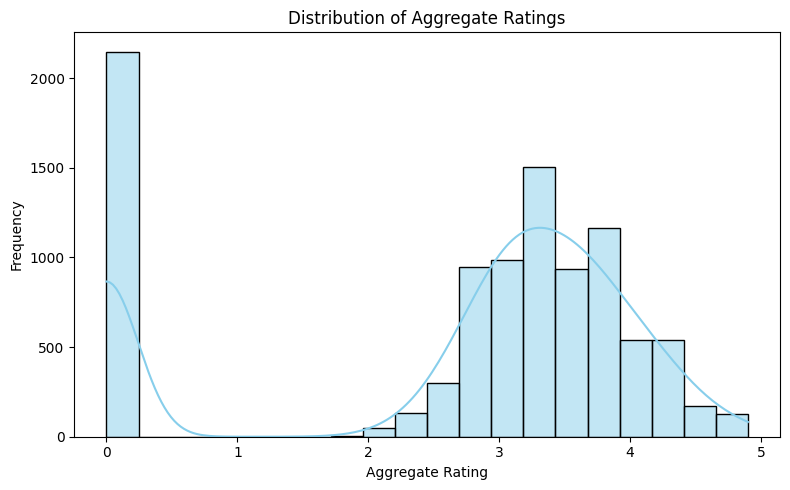

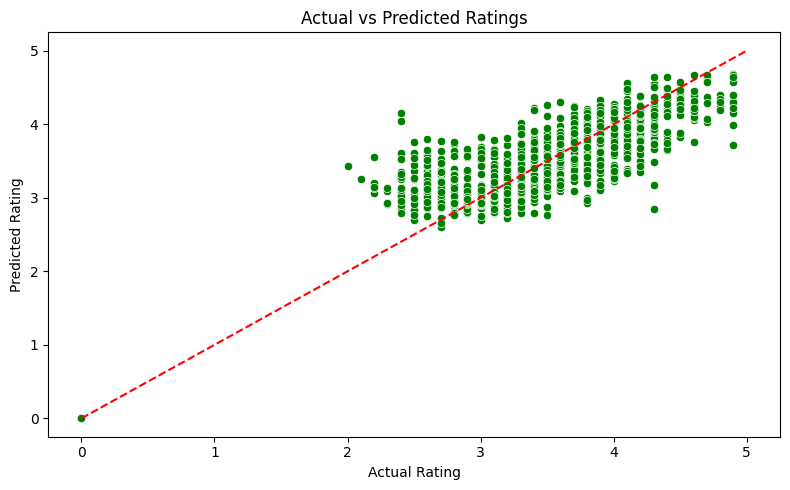

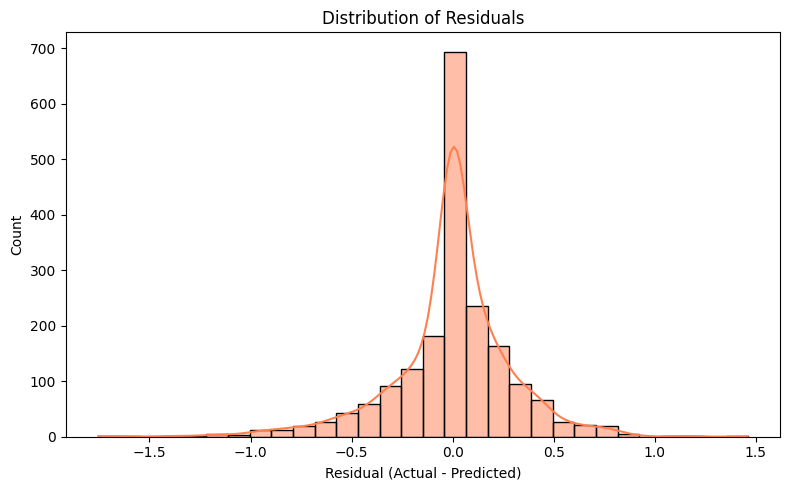

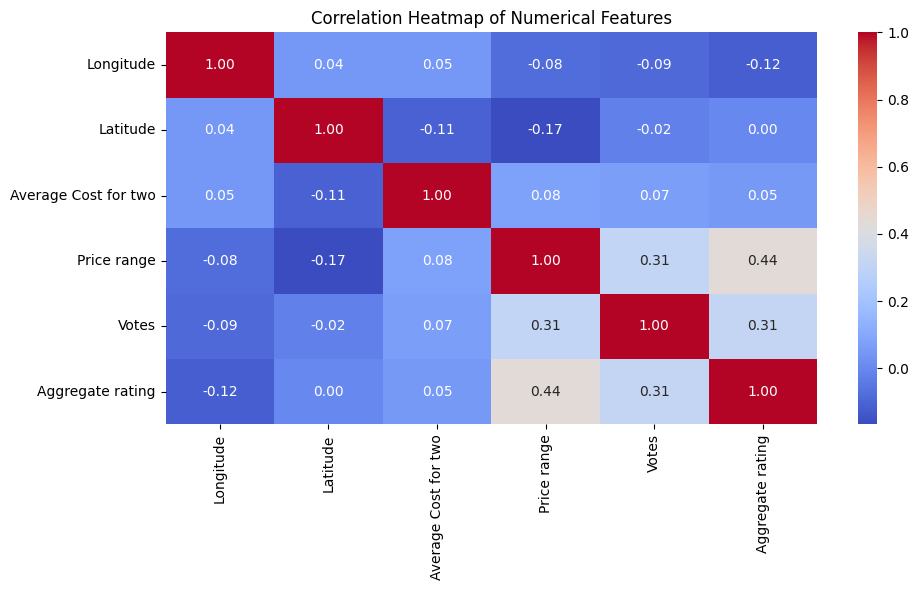

/tmp/ipython-input-5-440696959.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_features.values, y=top_10_features.index, palette="viridis")


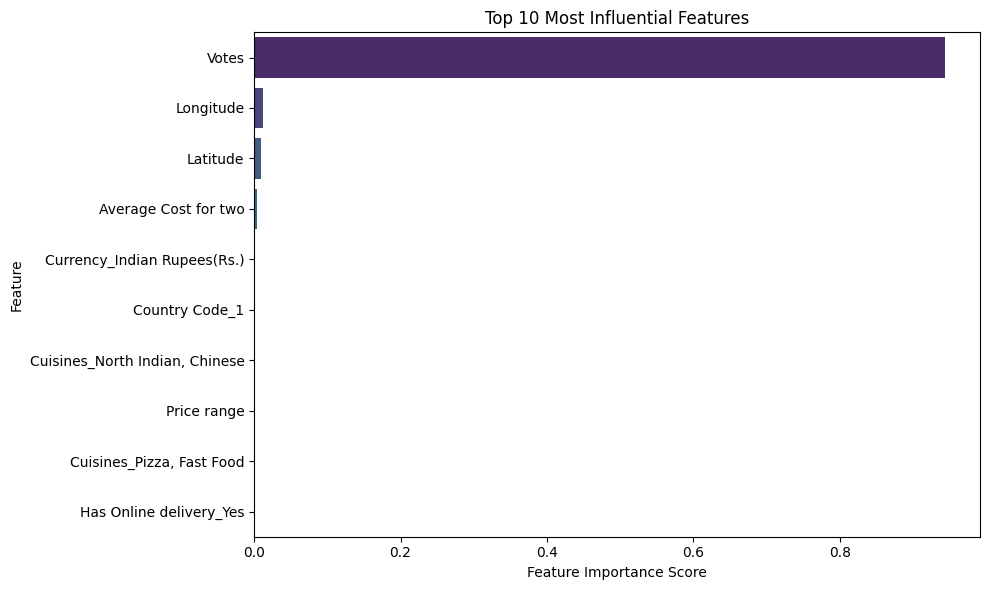

In [ ]:
# restaurant_rating_project.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# === 1. Load and Inspect Dataset ===
try:
    df = pd.read_csv('Dataset .csv')
except FileNotFoundError:
    print("❌ Dataset not found. Check file name and path.")
    sys.exit()

# === 2. Data Cleaning ===
# Drop non-informative columns
df.drop(columns=[
    'Restaurant ID', 'Restaurant Name', 'Address',
    'Locality Verbose', 'Rating color', 'Rating text'
], inplace=True)

# === 3. Define Features and Target ===
target = 'Aggregate rating'
features = [col for col in df.columns if col != target]

X = df[features]
y = df[target]

# === 4. Column Classification ===
numerical_cols = ['Longitude', 'Latitude', 'Average Cost for two', 'Price range', 'Votes']
categorical_cols = [
    'Country Code', 'City', 'Locality', 'Cuisines', 'Currency',
    'Has Table booking', 'Has Online delivery', 'Is delivering now', 'Switch to order menu'
]

# === 5. Preprocessing Pipelines ===
numeric_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

category_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_cols),
    ('cat', category_pipeline, categorical_cols)
])

# === 6. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 7. Model Pipeline ===
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# === 8. Train Model ===
model.fit(X_train, y_train)

# === 9. Evaluation ===
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Evaluation Metrics:")
print(f"Mean Squared Error     : {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error    : {mae:.4f}")
print(f"R² Score               : {r2:.4f}")

# === 10. Top 10 Important Features (Dynamic) ===
try:
    ohe = model.named_steps['preprocessor'].named_transformers_['cat']['encode']
    ohe_feature_names = ohe.get_feature_names_out(categorical_cols)
    final_feature_names = numerical_cols + list(ohe_feature_names)

    importances = model.named_steps['regressor'].feature_importances_
    feature_series = pd.Series(importances, index=final_feature_names)
    top_10_features = feature_series.sort_values(ascending=False).head(10)

    print("\n Top 10 Important Features:")
    print(top_10_features)

except Exception as e:
    print(f"⚠️ Unable to extract feature importances: {e}")

# === 11. Visualization Section ===

# 1. Distribution of Ratings
plt.figure(figsize=(8, 5))
sns.histplot(df['Aggregate rating'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Aggregate Ratings")
plt.xlabel("Aggregate Rating")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 2. Actual vs Predicted Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, color='green')
plt.plot([0, 5], [0, 5], 'r--')  # reference line
plt.title("Actual vs Predicted Ratings")
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.tight_layout()
plt.show()

# 3. Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='coral')
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()

# 4. Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_cols + [target]].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

# 5. Feature Importance Plot
try:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_10_features.values, y=top_10_features.index, palette="viridis")
    plt.title("Top 10 Most Influential Features")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
except:
    print("⚠️ Could not plot feature importance.")
